In [ ]:
import pandas as pd
import csv
import matplotlib.pyplot as plt

MESSAGE_CODE_FILTER = ["50102", "50103"]  # IiMTS04 aIMT

In [141]:
file_path = r"C:\Users\joacosta\Work\Beumer\NortFord\Data Analitics\Extracted\Log Monitor\10-04-2025\FullLog_From_20251003111400_To_20251004111400.csv"
raw_df = pd.read_csv(
    file_path,
    sep=";",
    header=None,
    engine="python",
    quoting=csv.QUOTE_NONE,
    skipinitialspace=True,
    on_bad_lines="skip",
    dtype=str
)

In [142]:
temp_df = raw_df.replace('"', '',regex=True)        # Remove all double quotes
temp_df = temp_df.replace(r"\s+", '',regex=True)    # Remove all whitespace

temp_df.columns = [
    "timeStamp", "flag", "systemName", "ipAddress", "sender", "unkown",
    "unkown_2", "timeStampPLC", "mainCabinetName", "messageCode", "sequenceNo",
    "rawMessage"
]

# timeStamp parsing
temp_df["timeStamp"] = pd.to_datetime(temp_df["timeStamp"], format="%y%m%d%H%M%S%f", errors="coerce")

# Filter to keep only rows with messageCode in MESSAGE_CODE_FILTER
original_records = len(temp_df)
temp_df = temp_df[temp_df["messageCode"].isin(MESSAGE_CODE_FILTER)].reset_index(drop=True)

remaining_records = len(temp_df)
dropped_count = original_records - remaining_records
print(f"Filtered dataset: kept {remaining_records} rows with messageCode in {MESSAGE_CODE_FILTER} "
      f"\n\tdropped {dropped_count} out of {original_records} total rows")

Filtered dataset: kept 41853 rows with messageCode in ['50102', '50103'] 
	dropped 1026404 out of 1068257 total rows


In [143]:
print(temp_df["rawMessage"].iloc[0])

->{event:iuItemMeasurement,inductionNo:6,indexNo,814,length:256,width:244,positionFront:257,positionBack:0,noOfCarriers:1,inductDelayOdd:262,inductDelayEven:222,carrierDelayOdd:101,carrierDelayEven:97}<


In [144]:
regex_fix_after_commas = r',\s*([A-Za-z_]\w*)\s*,\s*([-+]?\d+(?:\.\d+)?)'
regex_fix_before_commas = r'^\s*([A-Za-z_]\w*)\s*,\s*([-+]?\d+(?:\.\d+)?)'

In [145]:
# Message Column parsing
temp_df["rawMessage"] = temp_df["rawMessage"].str.removeprefix("->{").str.removesuffix("}<")
temp_df["rawMessage"] = temp_df["rawMessage"].str.replace(regex_fix_after_commas, r',\1:\2', regex=True)  # # fix ", key , 123" after commas
temp_df["rawMessage"] = temp_df["rawMessage"].str.replace(regex_fix_before_commas, r'\1:\2', regex=True)  # fix "key , 123" at the beginning (before the first comma)
message_df = temp_df["rawMessage"].str.split(",", expand=True)          # Split into columns
col_names = message_df.iloc[0].str.split(":", n=1).str[0].str.strip()   # Extract keys (before ':') from the first row as column names
message_df.columns = col_names                                          # Assign new column names
message_df = message_df.apply(lambda x: x.str.split(":", n=1).str[1])   # Keep only values (after ':')
message_df = message_df.apply(pd.to_numeric, errors="ignore")            # Convert to numeric where possible


C:\Users\joacosta\AppData\Local\Temp\ipykernel_30356\2323745790.py:9: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  message_df = message_df.apply(pd.to_numeric, errors="ignore")            # Convert to numeric where possible


In [146]:
message_df.head(1)

,event,inductionNo,indexNo,length,width,positionFront,positionBack,noOfCarriers,inductDelayOdd,inductDelayEven,carrierDelayOdd,carrierDelayEven
0,iuItemMeasurement,6,814,256,244,257,0,1,262,222,101,97.0


In [147]:
# Induction Mapping
induction_map = {
    0: "IU001",
    1: "IU002",
    2: "IU003",
    3: "IU004",
    4: "IU005",
    5: "IU006",
    6: "IU007",
    100: "SPS001",
    101: "SPS002",
    }

# Map InductionNo with the real world names (unknowns -> "No Map Yet")
message_df["inductionNo"] = message_df["inductionNo"].map(induction_map).fillna("No Map Yet")

In [148]:
# Join dataframes
parsed_df = pd.concat([temp_df.drop(columns=["rawMessage"]), message_df], axis=1)
parsed_df = parsed_df.apply(pd.to_numeric, errors="ignore")

C:\Users\joacosta\AppData\Local\Temp\ipykernel_30356\2780915994.py:3: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  parsed_df = parsed_df.apply(pd.to_numeric, errors="ignore")


In [149]:
parsed_df.describe()

,timeStamp,unkown,unkown_2,messageCode,indexNo,length,width,positionFront,positionBack,noOfCarriers,inductDelayOdd,inductDelayEven,carrierDelayOdd,carrierDelayEven
count,4.185300e+04,0.0,0.0,41853.000000,41853.000000,41853.000000,41853.000000,41853.000000,41853.0,41853.000000,41853.000000,41853.000000,41853.000000,36261.000000
mean,1.759519e+18,NaN,NaN,50102.133610,1010.299071,323.915227,359.657109,369.747282,0.0,1.133610,241.240771,184.148591,85.431940,87.356526
std,2.879812e+13,NaN,NaN,0.340237,576.641912,102.489213,152.417284,131.613360,0.0,0.340237,29.510629,44.875195,12.568607,8.554280
min,1.759450e+18,NaN,NaN,50102.000000,1.000000,0.000000,0.000000,11.000000,0.0,1.000000,52.000000,12.000000,33.000000,33.000000
25%,1.759494e+18,NaN,NaN,50102.000000,512.000000,248.000000,263.000000,275.000000,0.0,1.000000,226.000000,171.000000,79.000000,83.000000
50%,1.759513e+18,NaN,NaN,50102.000000,1018.000000,323.000000,340.000000,352.000000,0.0,1.000000,245.000000,198.000000,85.000000,87.000000
75%,1.759531e+18,NaN,NaN,50102.000000,1509.000000,384.000000,419.000000,432.000000,0.0,1.000000,261.000000,214.000000,93.000000,93.000000
max,1.759577e+18,NaN,NaN,50103.000000,1999.000000,1364.000000,1613.000000,1134.000000,0.0,2.000000,351.000000,305.000000,137.000000,133.000000


In [150]:
parsed_df.select_dtypes(include=['object', 'category']).describe()

,flag,systemName,ipAddress,sender,timeStampPLC,mainCabinetName,sequenceNo,event,inductionNo
count,41853,41853,41853,41853,41853,41853,41853,41853,41853
unique,1,1,1,1,41772,1,256,1,7
top,N,SMC,10.158.244.100:7200,Induction.Item,"11:21:34,397",MC01,SQ056,iuItemMeasurement,IU004
freq,41853,41853,41853,41853,2,41853,207,41853,8792


In [151]:
cols_to_drop = parsed_df.columns[parsed_df.nunique() == 1].tolist()
print(f"Dropping {len(cols_to_drop)} columns with a single unique value: {cols_to_drop}")
clean_df = parsed_df.drop(columns=cols_to_drop)

clean_df = clean_df.dropna(axis=1, how="all")
clean_df.info()

Dropping 7 columns with a single unique value: ['flag', 'systemName', 'ipAddress', 'sender', 'mainCabinetName', 'event', 'positionBack']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41853 entries, 0 to 41852
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   timeStamp         41853 non-null  int64  
 1   timeStampPLC      41853 non-null  object 
 2   messageCode       41853 non-null  int64  
 3   sequenceNo        41853 non-null  object 
 4   inductionNo       41853 non-null  object 
 5   indexNo           41853 non-null  int64  
 6   length            41853 non-null  int64  
 7   width             41853 non-null  int64  
 8   positionFront     41853 non-null  int64  
 9   noOfCarriers      41853 non-null  int64  
 10  inductDelayOdd    41853 non-null  int64  
 11  inductDelayEven   41853 non-null  int64  
 12  carrierDelayOdd   41853 non-null  int64  
 13  carrierDelayEven  36261 non-null  float64
dt

In [152]:
clean_df.describe()

,timeStamp,messageCode,indexNo,length,width,positionFront,noOfCarriers,inductDelayOdd,inductDelayEven,carrierDelayOdd,carrierDelayEven
count,4.185300e+04,41853.000000,41853.000000,41853.000000,41853.000000,41853.000000,41853.000000,41853.000000,41853.000000,41853.000000,36261.000000
mean,1.759519e+18,50102.133610,1010.299071,323.915227,359.657109,369.747282,1.133610,241.240771,184.148591,85.431940,87.356526
std,2.879812e+13,0.340237,576.641912,102.489213,152.417284,131.613360,0.340237,29.510629,44.875195,12.568607,8.554280
min,1.759450e+18,50102.000000,1.000000,0.000000,0.000000,11.000000,1.000000,52.000000,12.000000,33.000000,33.000000
25%,1.759494e+18,50102.000000,512.000000,248.000000,263.000000,275.000000,1.000000,226.000000,171.000000,79.000000,83.000000
50%,1.759513e+18,50102.000000,1018.000000,323.000000,340.000000,352.000000,1.000000,245.000000,198.000000,85.000000,87.000000
75%,1.759531e+18,50102.000000,1509.000000,384.000000,419.000000,432.000000,1.000000,261.000000,214.000000,93.000000,93.000000
max,1.759577e+18,50103.000000,1999.000000,1364.000000,1613.000000,1134.000000,2.000000,351.000000,305.000000,137.000000,133.000000


In [154]:
clean_df.select_dtypes(include=['object', 'category']).describe()

,timeStampPLC,sequenceNo,inductionNo
count,41853,41853,41853
unique,41772,256,7
top,"11:21:34,397",SQ056,IU004
freq,2,207,8792


In [155]:
# we need to conver message code into a categorical column right now is just 50102 and 50103

clean_df["messageCode"] = clean_df["messageCode"].astype("category")

In [156]:
clean_df.describe()

,timeStamp,indexNo,length,width,positionFront,noOfCarriers,inductDelayOdd,inductDelayEven,carrierDelayOdd,carrierDelayEven
count,4.185300e+04,41853.000000,41853.000000,41853.000000,41853.000000,41853.000000,41853.000000,41853.000000,41853.000000,36261.000000
mean,1.759519e+18,1010.299071,323.915227,359.657109,369.747282,1.133610,241.240771,184.148591,85.431940,87.356526
std,2.879812e+13,576.641912,102.489213,152.417284,131.613360,0.340237,29.510629,44.875195,12.568607,8.554280
min,1.759450e+18,1.000000,0.000000,0.000000,11.000000,1.000000,52.000000,12.000000,33.000000,33.000000
25%,1.759494e+18,512.000000,248.000000,263.000000,275.000000,1.000000,226.000000,171.000000,79.000000,83.000000
50%,1.759513e+18,1018.000000,323.000000,340.000000,352.000000,1.000000,245.000000,198.000000,85.000000,87.000000
75%,1.759531e+18,1509.000000,384.000000,419.000000,432.000000,1.000000,261.000000,214.000000,93.000000,93.000000
max,1.759577e+18,1999.000000,1364.000000,1613.000000,1134.000000,2.000000,351.000000,305.000000,137.000000,133.000000


In [157]:
clean_df.select_dtypes(include=['object', 'category']).describe()

,timeStampPLC,messageCode,sequenceNo,inductionNo
count,41853,41853,41853,41853
unique,41772,2,256,7
top,"11:21:34,397",50102,SQ056,IU004
freq,2,36261,207,8792


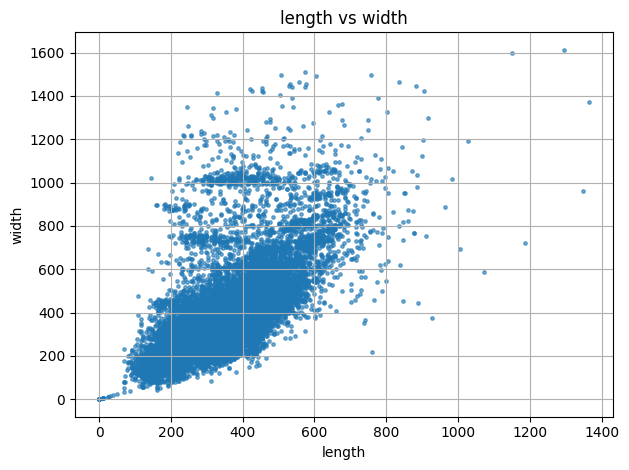

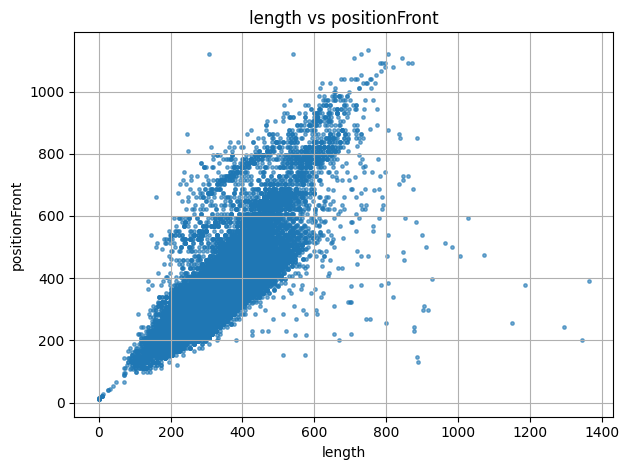

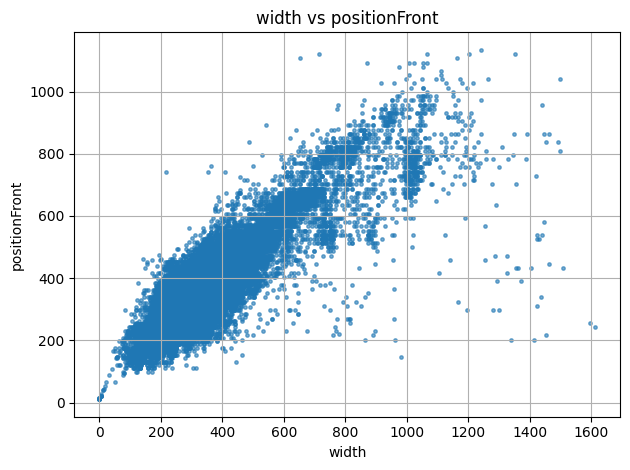

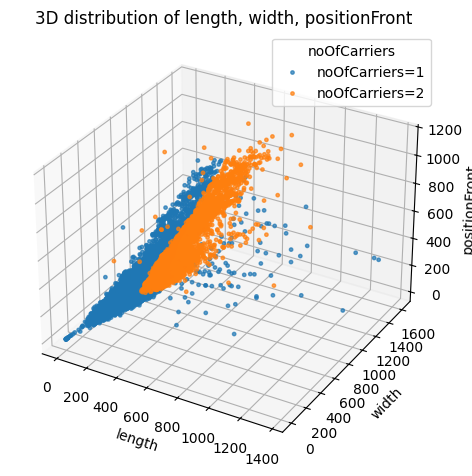

In [ ]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (needed for 3D)

# --- CONFIG ---
X, Y, Z = "length", "width", "positionFront"
GROUP = "noOfCarriers"   # used to color series in the 3D plot
MAX_POINTS = 50000       # subsample for speed if needed

# Make sure the columns exist and are numeric
for col in [X, Y, Z, GROUP]:
    if col in clean_df.columns:
        clean_df[col] = pd.to_numeric(clean_df[col], errors="coerce")

# Drop rows missing the key columns
df = clean_df[[X, Y, Z, GROUP]].dropna(subset=[X, Y, Z]).copy()

# Optional: subsample (preserves distribution reasonably for big datasets)
if len(df) > MAX_POINTS:
    df = df.sample(MAX_POINTS, random_state=42)

# 1) length vs width
plt.figure()
plt.scatter(df[X], df[Y], s=6, alpha=0.6)
plt.xlabel(X)
plt.ylabel(Y)
plt.title(f"{X} vs {Y}")
plt.grid(True)
plt.tight_layout()

# 2) length vs positionFront
plt.figure()
plt.scatter(df[X], df[Z], s=6, alpha=0.6)
plt.xlabel(X)
plt.ylabel(Z)
plt.title(f"{X} vs {Z}")
plt.grid(True)
plt.tight_layout()

# 3) width vs positionFront
plt.figure()
plt.scatter(df[Y], df[Z], s=6, alpha=0.6)
plt.xlabel(Y)
plt.ylabel(Z)
plt.title(f"{Y} vs {Z}")
plt.grid(True)
plt.tight_layout()

# 4) 3D scatter (length, width, positionFront) with different colors per group (default color cycle)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

if GROUP in df.columns:
    # Plot each group separately to get different default colors and a legend
    for g, gdf in df.groupby(GROUP):
        ax.scatter(gdf[X], gdf[Y], gdf[Z], s=6, alpha=0.7, label=f"{GROUP}={g}") # type: ignore
    ax.legend(title=GROUP)
else:
    ax.scatter(df[X], df[Y], df[Z], s=6, alpha=0.7) # type: ignore

ax.set_xlabel(X)
ax.set_ylabel(Y)
ax.set_zlabel(Z)
ax.set_title(f"3D distribution of {X}, {Y}, {Z}")
plt.tight_layout()

plt.show()



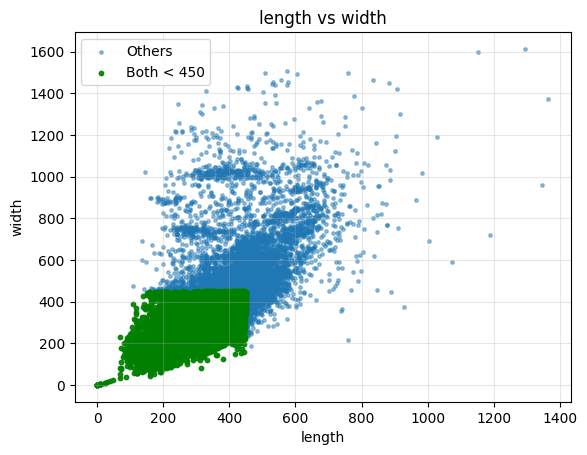

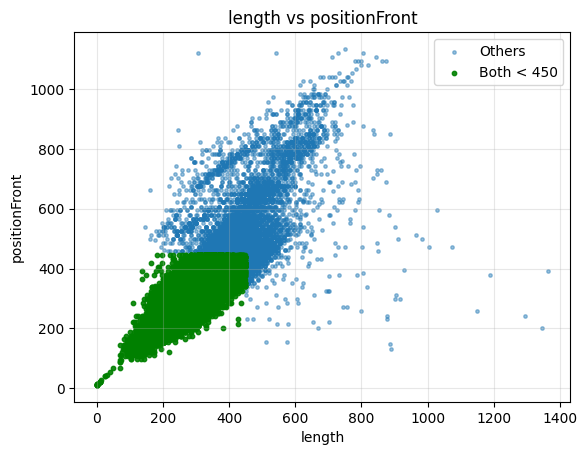

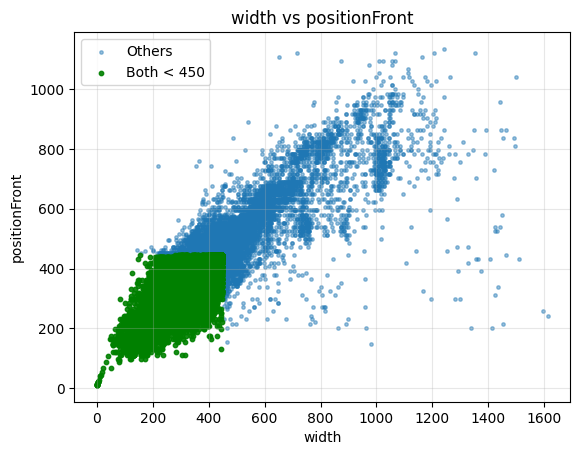

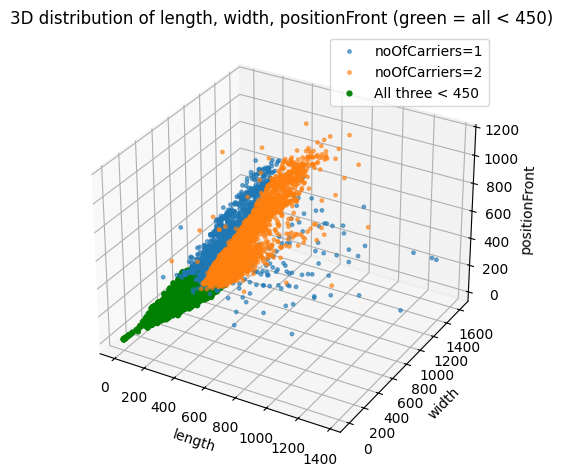

In [ ]:
# --- CONFIG ---
X, Y, Z = "length", "width", "positionFront"
GROUP = "noOfCarriers"   # used for coloring "others" in 3D (keeps your distribution colors)
THRESH = 450
MAX_POINTS = 50000

# Ensure numeric
for col in [X, Y, Z, GROUP]:
    if col in clean_df.columns:
        clean_df[col] = pd.to_numeric(clean_df[col], errors="coerce")

# Drop rows missing the key columns
df = clean_df[[X, Y, Z, GROUP]].dropna(subset=[X, Y, Z]).copy()

# Optional subsample
if len(df) > MAX_POINTS:
    df = df.sample(MAX_POINTS, random_state=42)

# ---------- Helper to make 2D plot with green mask ----------
def scatter_2d(ax, df, a, b, thresh=THRESH, title=None):
    mask_valid = df[a].notna() & df[b].notna()
    mask_green = mask_valid & (df[a] < thresh) & (df[b] < thresh)

    # Plot others first (default color), then green on top
    ax.scatter(df.loc[mask_valid & ~mask_green, a],
               df.loc[mask_valid & ~mask_green, b],
               s=6, alpha=0.45, label="Others")

    ax.scatter(df.loc[mask_green, a],
               df.loc[mask_green, b],
               s=10, alpha=0.9, color="green", label=f"Both < {thresh}")

    ax.set_xlabel(a)
    ax.set_ylabel(b)
    if title:
        ax.set_title(title)
    ax.grid(True, alpha=0.3)
    ax.legend()

# 1) length vs width
fig, ax = plt.subplots()
scatter_2d(ax, df, X, Y, title=f"{X} vs {Y}")

# 2) length vs positionFront
fig, ax = plt.subplots()
scatter_2d(ax, df, X, Z, title=f"{X} vs {Z}")

# 3) width vs positionFront
fig, ax = plt.subplots()
scatter_2d(ax, df, Y, Z, title=f"{Y} vs {Z}")

# ---------- 3D plot with green mask ----------
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

mask_valid_3d = df[X].notna() & df[Y].notna() & df[Z].notna()
mask_green_3d = mask_valid_3d & (df[X] < THRESH) & (df[Y] < THRESH) & (df[Z] < THRESH)

# Plot "others" first, grouped (keeps distinct default colors for categories)
others = df.loc[mask_valid_3d & ~mask_green_3d]
if GROUP in others.columns:
    for g, gdf in others.groupby(GROUP):
        ax.scatter(gdf[X], gdf[Y], gdf[Z], s=6, alpha=0.6, label=f"{GROUP}={g}")    # type: ignore
else:
    ax.scatter(others[X], others[Y], others[Z], s=6, alpha=0.6, label="Others")  # type: ignore

# Plot the green cluster on top
greens = df.loc[mask_green_3d]
if not greens.empty:
    ax.scatter(greens[X], greens[Y], greens[Z], s=12, alpha=0.95, color="green", label=f"All three < {THRESH}")     # type: ignore

ax.set_xlabel(X)
ax.set_ylabel(Y)
ax.set_zlabel(Z)
ax.set_title(f"3D distribution of {X}, {Y}, {Z} (green = all < {THRESH})")
ax.legend()
plt.tight_layout()

plt.show()
